In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
import datetime as dt

## Procesamiento de datos

In [161]:
dataset_sube = pd.read_csv('data/sube-2023.csv')

### Ejercicio 1

#### a)

In [162]:
dataset_sube['DIA_TRANSPORTE'] = pd.to_datetime(dataset_sube['DIA_TRANSPORTE'], format='%Y-%m-%d')

#### b)

##### i.

In [163]:
def obtener_nombre_dia(fecha_dia):
    dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    return dias[fecha_dia.weekday()]

In [164]:
dataset_sube['FECHA_DIA'] = dataset_sube['DIA_TRANSPORTE'].apply(obtener_nombre_dia)

##### ii.

In [165]:
dataset_sube['FECHA_ORDINAL'] = dataset_sube['DIA_TRANSPORTE'].dt.day_of_year

##### iii.

In [166]:
dataset_sube

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA,FECHA_ORDINAL
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,Domingo,1
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,Domingo,1
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO,Domingo,1
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO,Domingo,1
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO,Domingo,1
...,...,...,...,...,...,...,...,...,...,...,...,...
472286,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL A,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,28,NO,Domingo,365
472287,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL B,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,38,NO,Domingo,365
472288,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL C,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,54,NO,Domingo,365
472289,2023-12-31,S.A TRANSPORTE CIUDAD DE RIO CUARTO,TRONCAL D,NO,COLECTIVO,MUNICIPAL,CORDOBA,RIO CUARTO,52,NO,Domingo,365


### Ejercicio 2

### Ejercicio 3

## Analisis exploratorio

### Ejercicio 4

## Modelado

### Ejercicio 5

In [167]:
dataset_sube20 = pd.read_csv('data/dat-ab-usos-2020.csv')
dataset_sube21 = pd.read_csv('data/dat-ab-usos-2021.csv')
dataset_sube22 = pd.read_csv('data/dat-ab-usos-2022.csv')
#creo un nuevo DataFrame con todos los años
df_concatenado = pd.concat([dataset_sube20,dataset_sube21,dataset_sube22,dataset_sube])

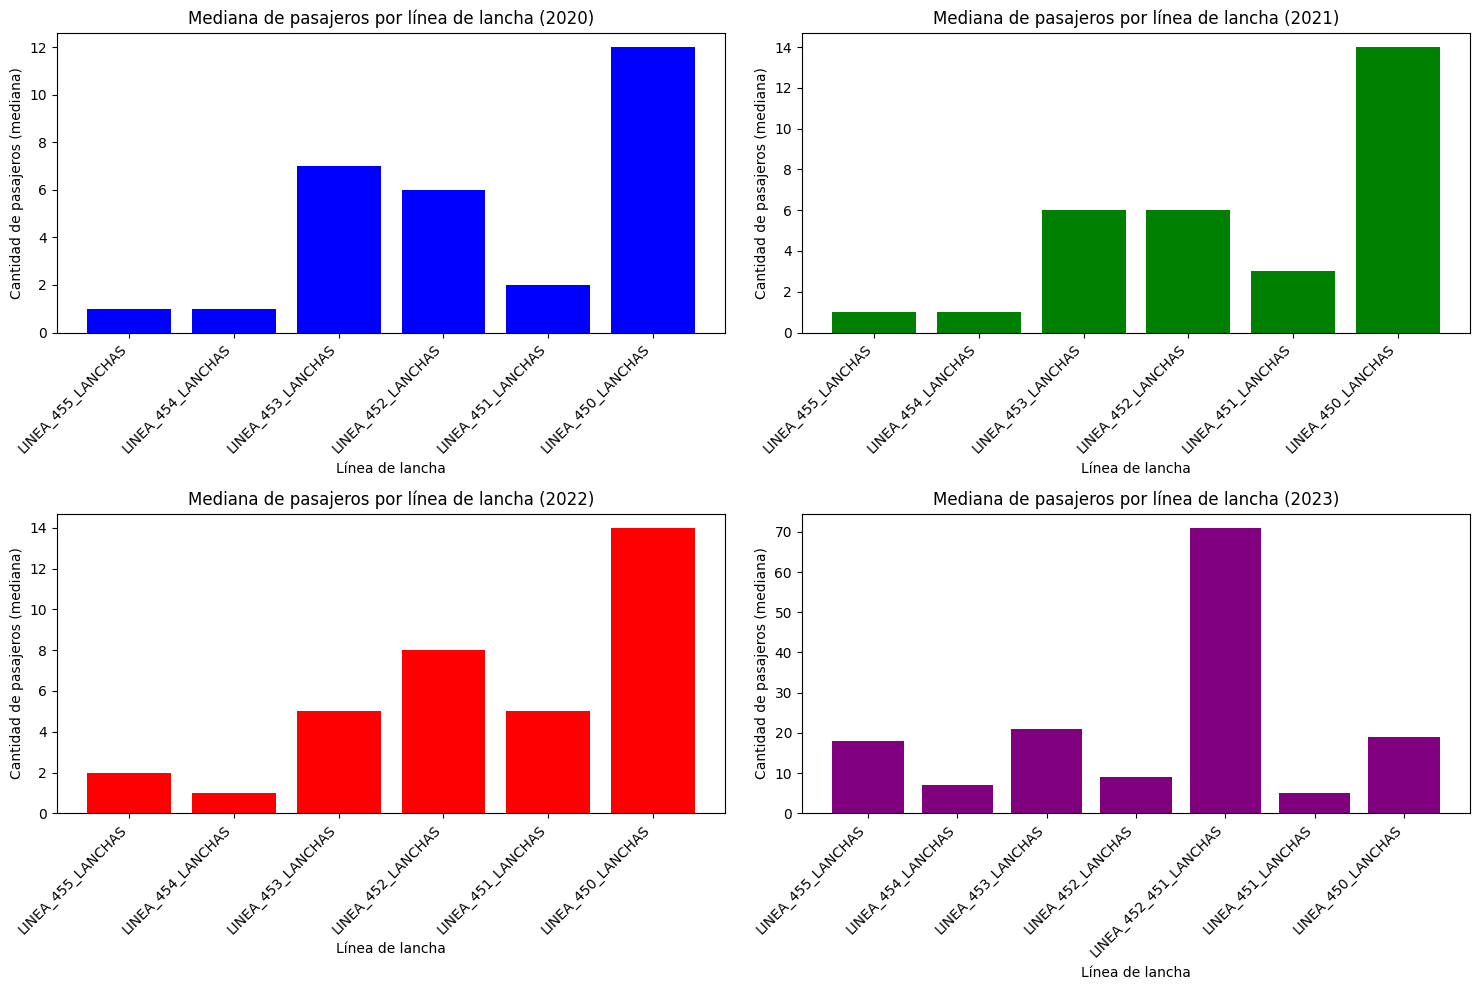

In [168]:
# Creo una columna para el año en el nuevo dataframe
df_concatenado['DIA_TRANSPORTE'] = pd.to_datetime(df_concatenado['DIA_TRANSPORTE'])
df_concatenado['AÑO'] = df_concatenado['DIA_TRANSPORTE'].dt.year

# Filtro los datos solo para lanchas
lanchas_data = df_concatenado[df_concatenado['TIPO_TRANSPORTE'] == 'LANCHAS']

# Creo una función para obtener las medianas por año
def obtener_medianas_por_año(data, year):
    data_año = data[data['AÑO'] == year]
    medianas = data_año.groupby('LINEA')['CANTIDAD'].median().reset_index()
    return medianas.sort_values(by='LINEA', ascending=False)

# Obtengo las medianas para cada año en especifico
lanchas_medianas20 = obtener_medianas_por_año(lanchas_data, 2020)
lanchas_medianas21 = obtener_medianas_por_año(lanchas_data, 2021)
lanchas_medianas22 = obtener_medianas_por_año(lanchas_data, 2022)
lanchas_medianas23 = obtener_medianas_por_año(lanchas_data, 2023)

# Creo una nueva figura y ejes para el gráfico combinado
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 2020
axes[0, 0].bar(lanchas_medianas20['LINEA'], lanchas_medianas20['CANTIDAD'], color='b')
axes[0, 0].set_title('Mediana de pasajeros por línea de lancha (2020)')
axes[0, 0].set_xlabel('Línea de lancha')
axes[0, 0].set_ylabel('Cantidad de pasajeros (mediana)')
plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

# Gráfico 2021
axes[0, 1].bar(lanchas_medianas21['LINEA'], lanchas_medianas21['CANTIDAD'], color='g')
axes[0, 1].set_title('Mediana de pasajeros por línea de lancha (2021)')
axes[0, 1].set_xlabel('Línea de lancha')
axes[0, 1].set_ylabel('Cantidad de pasajeros (mediana)')
plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# Gráfico 2022
axes[1, 0].bar(lanchas_medianas22['LINEA'], lanchas_medianas22['CANTIDAD'], color='r')
axes[1, 0].set_title('Mediana de pasajeros por línea de lancha (2022)')
axes[1, 0].set_xlabel('Línea de lancha')
axes[1, 0].set_ylabel('Cantidad de pasajeros (mediana)')
plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# Gráfico 2023
axes[1, 1].bar(lanchas_medianas23['LINEA'], lanchas_medianas23['CANTIDAD'], color='purple')
axes[1, 1].set_title('Mediana de pasajeros por línea de lancha (2023)')
axes[1, 1].set_xlabel('Línea de lancha')
axes[1, 1].set_ylabel('Cantidad de pasajeros (mediana)')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

# Ajusto el espacio entre los subgráficos
plt.tight_layout()

# Muestro el gráfico
plt.show()

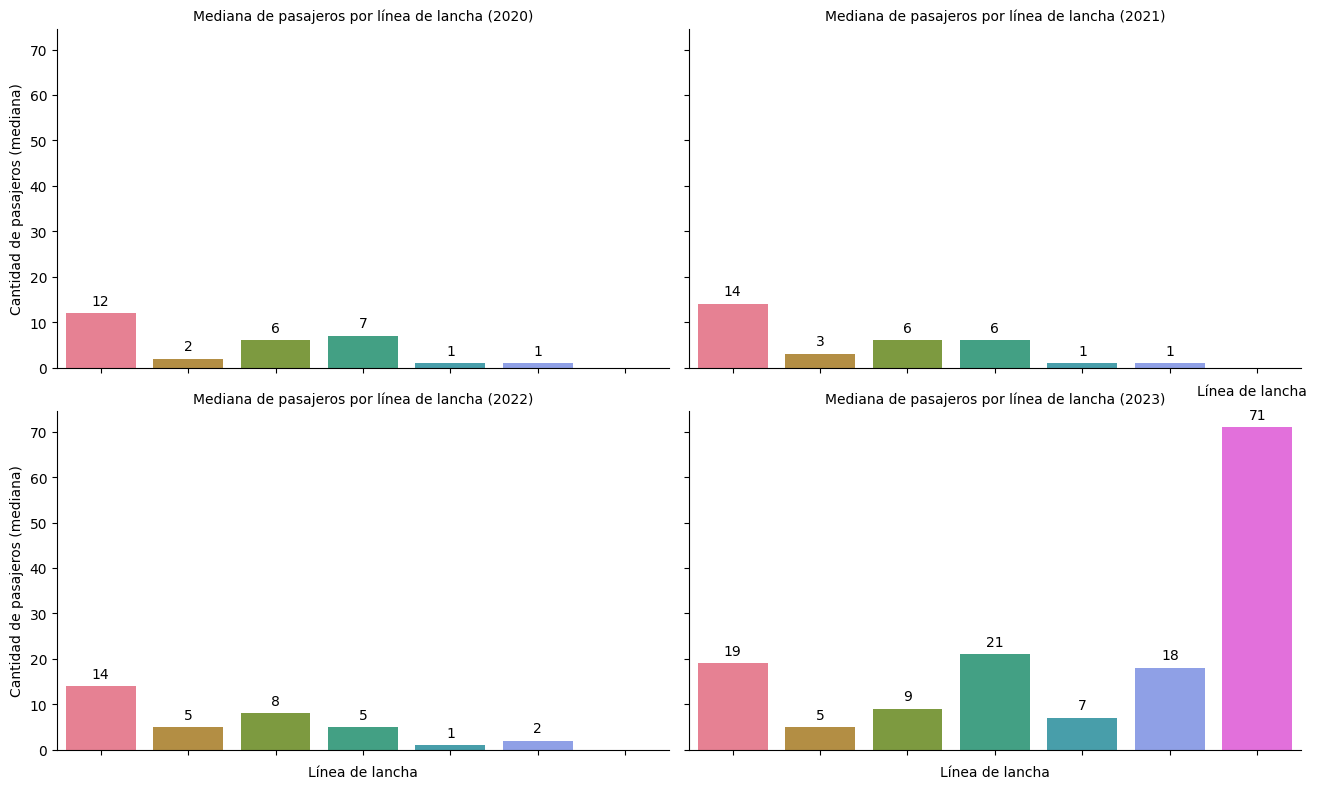

In [171]:
# Creo una columna para el año
df_concatenado['DIA_TRANSPORTE'] = pd.to_datetime(df_concatenado['DIA_TRANSPORTE'])
df_concatenado['AÑO'] = df_concatenado['DIA_TRANSPORTE'].dt.year

# Filtrao los datos para lanchas
lanchas_data = df_concatenado[df_concatenado['TIPO_TRANSPORTE'] == 'LANCHAS']

# Agrupo y calculo la mediana de la cantidad de pasajeros por línea y año
lanchas_medianas = lanchas_data.groupby(['AÑO', 'LINEA'])['CANTIDAD'].median().reset_index()

# Asigno colores a cada línea
palette = sns.color_palette("husl", len(lanchas_medianas['LINEA'].unique()))

# Creo el gráfico
g = sns.catplot(
    data=lanchas_medianas, 
    x='LINEA', 
    y='CANTIDAD', 
    col='AÑO', 
    hue='LINEA', 
    kind='bar', 
    col_wrap=2, 
    height=4, 
    aspect=1.5,
    palette=palette,
)

# Ajusto los títulos y etiquetas
g.set_titles('Mediana de pasajeros por línea de lancha ({col_name})')
g.set_axis_labels('Línea de lancha', 'Cantidad de pasajeros (mediana)')
g.set_xticklabels(rotation=45, ha='right')

# Agrego leyenda
g.add_legend(title='Línea de lancha')

# Agrego etiquetas con los nombres de las líneas a las barras
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

# Ajusto el espacio entre los subgráficos
plt.tight_layout()

# Muestro el gráfico combinado
plt.show()
